In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import warnings
import logging
import absl.logging
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Suppress warnings
warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)

# Define dataset paths
normal_audio_dir = "/content/drive/MyDrive/final_year_project/archive (1)/patient-vocal-dataset/patient-vocal-dataset/Normal"
vox_Senilis_audio_dir = "/content/drive/MyDrive/final_year_project/archive (1)/patient-vocal-dataset/patient-vocal-dataset/Vox senilis"
laryngozele_audio_dir = "/content/drive/MyDrive/final_year_project/archive (1)/patient-vocal-dataset/patient-vocal-dataset/Laryngozele"

data = []

# Load audio file paths and labels
for label, directory in enumerate([normal_audio_dir, vox_Senilis_audio_dir, laryngozele_audio_dir]):
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            data.append((os.path.join(directory, filename), label))

df = pd.DataFrame(data, columns=["audio_path", "label"])

# Function to extract 2D MFCC features
def extract_mfcc_2d(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs.T  # Transpose to ensure uniform shape

# Extract MFCC features
df["mfcc_features"] = df["audio_path"].apply(extract_mfcc_2d)

# Convert data to numpy array
X = np.array(df["mfcc_features"].tolist(), dtype=object)

# Ensure uniform shape
max_length = max(mfcc.shape[0] for mfcc in X)
X = np.array([np.pad(mfcc, ((0, max_length - mfcc.shape[0]), (0, 0)), mode='constant') for mfcc in X])
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Shape: (samples, height, width, 1)

y = to_categorical(df["label"], num_classes=3)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build 2D CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    LSTM(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 7587, 38, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3793, 19, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3791, 17, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1895, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 970240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │   124,190,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,210,051 (473.82 MB)

 Trainable params: 124,210,051 (473.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.5404 - loss: 27.0221 - val_accuracy: 0.7644 - val_loss: 0.7040
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.7430 - loss: 0.6308 - val_accuracy: 0.7837 - val_loss: 0.5920
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.7898 - loss: 0.4902 - val_accuracy: 0.8317 - val_loss: 0.4424
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.8662 - loss: 0.2968 - val_accuracy: 0.8413 - val_loss: 0.4010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8918 - loss: 0.2840 - val_accuracy: 0.8365 - val_loss: 0.4225
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9038 - loss: 0.3170 - val_accuracy: 0.8029 - val_loss: 0.4188
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9188 - loss: 0.2292 - val_accuracy: 0.8077 - val_loss: 0.4583
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9304 - loss: 0.2020 - val_accuracy

In [ ]:
# model.save("dysarthria_model.h5")

output_dir = "/content/drive/MyDrive/final_year_project/output"
os.makedirs(output_dir, exist_ok=True)
model.save(os.path.join(output_dir, "dysarthria_model.h5"))

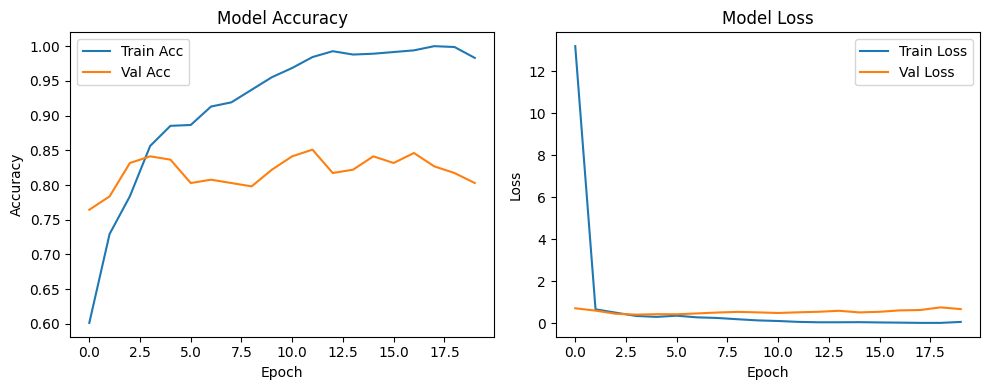

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "training_validation_curves.png"))
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
              precision    recall  f1-score   support

      Normal       0.86      0.83      0.85       115
 Vox-Senilis       0.79      0.84      0.81        80
 Laryngozele       0.36      0.31      0.33        13

    accuracy                           0.80       208
   macro avg       0.67      0.66      0.66       208
weighted avg       0.80      0.80      0.80       208



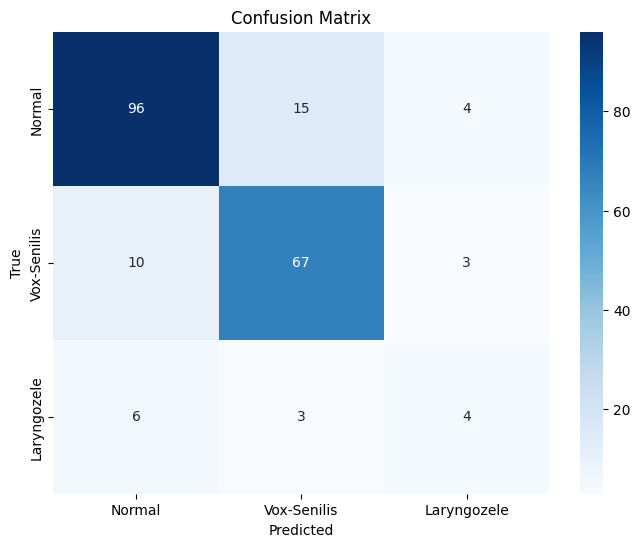

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

CLASS_LABELS = {0: "Normal", 1: "Vox-Senilis", 2: "Laryngozele"}

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=CLASS_LABELS.values()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_LABELS.values(), yticklabels=CLASS_LABELS.values(), cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model

CLASS_LABELS = {0: "Normal", 1: "Vox-Senilis", 2: "Laryngozele"}

def predict_audio_class(audio_path, model):
    # Extract MFCC features
    mfcc_features = extract_mfcc_2d(audio_path)  # Your function

    # Ensure the shape matches the expected (7589, 40)
    target_length = 7589  # Model's expected input length
    current_length = mfcc_features.shape[0]

    if current_length < target_length:
        # Zero-pad if MFCC is shorter
        mfcc_features = np.pad(mfcc_features, ((0, target_length - current_length), (0, 0)), mode='constant')
    else:
        # Trim if MFCC is too long
        mfcc_features = mfcc_features[:target_length, :]

    # Reshape to match CNN input (batch_size, time_steps, features, channels)
    mfcc_features = np.expand_dims(mfcc_features, axis=-1)  # Add channel dimension
    test_input = np.expand_dims(mfcc_features, axis=0)  # Add batch dimension


    # Predict using the trained model
    predictions = model.predict(test_input)

    # Print prediction probabilities for debugging
    print(f"Prediction probabilities: {predictions}")

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    return CLASS_LABELS[predicted_class]

# Load the trained model
# model = load_model('dysarthria_model.h5')

model = load_model(os.path.join(output_dir, "dysarthria_model.h5"))


# Define the path to the testing dataset
testing_dataset_dir = "/content/drive/MyDrive/final_year_project/Testing"

# Iterate through each subfolder and predict the class of each audio file
for subfolder in os.listdir(testing_dataset_dir):
    subfolder_path = os.path.join(testing_dataset_dir, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing folder: {subfolder}")
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".wav"):
                audio_path = os.path.join(subfolder_path, filename)
                predicted_label = predict_audio_class(audio_path, model)
                print(f"File: {filename} - Predicted class: {predicted_label}")


Processing folder: Female
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Prediction probabilities: [[0.00734237 0.00103999 0.9916176 ]]
File: 1205-a_lhl-egg.wav - Predicted class: Laryngozele
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction probabilities: [[4.068854e-02 3.910915e-04 9.589204e-01]]
File: 1205-phrase-egg.wav - Predicted class: Laryngozele
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction probabilities: [[1.0535521e-02 9.8946124e-01 3.1722841e-06]]
File: 4-a_lhl-egg.wav - Predicted class: Vox-Senilis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction probabilities: [[1.4293204e-06 9.9999857e-01 3.7200498e-10]]
File: 816-a_n-egg.wav - Predicted class: Vox-Senilis
Processing folder: Male
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction probabilities: [[1.2979872e-03 3.2980683e-06 9.9869871e-01]]
File: 1205-i_l.wav - Predicted class: Laryngozele
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction probabilities: [[9.7843164e-01 2.1567822e-02 5.8932818e-07]]
File: 4-i_l.wav - Predicted clas